In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from celluloid import Camera
from collections import deque
from matplotlib import animation

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.semi_random_player import SemiRandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

# %matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

In [3]:
MODEL_VERSION = 'v8'
TRAIN_MODE = 'semi_random' # self_play / random / semi_random
INITIAL_BID_NORMALIZER = 200 # 100 if action is relative to current coins, 200 if relative to total coins

In [4]:
def run_validation(players, n_episodes_validation):
    game_controller = GameController()
    validation_players = [players[0], SemiRandomPlayer(1, game_controller.game)]
    game_controller.load_validation(validation_players)

    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [5]:
def get_critic_value(agent_critic, initial_state, bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/INITIAL_BID_NORMALIZER
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()

def get_all_critic_values(drl_player, initial_state):
    agent_critic = drl_player.agent.agent.critic_local
    return [[get_critic_value(agent_critic, initial_state, bid, board_move) for bid in range(101)] \
                for board_move in range(9)]   

In [6]:
def plot_critic_values(drl_player, critic_values, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(3, 3, figsize=(12, 8))
    for board_move in range(9):
        axx = ax[board_move//3, board_move%3]
        axx.set_xlabel('Bid value')
        axx.set_ylabel('Quality of move')
        axx.set_title(f'Board move {board_move}')
        axx.plot(critic_values[board_move])
    fig.tight_layout()
#     plt.savefig('test.png')

In [7]:
def create_animation(critic_values_by_episode, drl_player, fps=10, filename='critic_values.mp4'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    camera = Camera(fig)
    initial_index = 0
    while initial_index+1<len(critic_values_by_episode) and \
            critic_values_by_episode[initial_index] == critic_values_by_episode[initial_index+1]:
        initial_index += 1

    for i in range(initial_index, len(critic_values_by_episode)):
        critic_values = critic_values_by_episode[i]
        i += 1
        plot_critic_values(drl_player, critic_values, fig, ax);
        plt.pause(0.1)
        camera.snap()

    anim = camera.animate()
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(filename, writer=FFwriter);

In [8]:
def init_train(game_controller, players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, save_critic_value_each=100, save_animation_each=1000, eps_start=1.0,
                   eps_end=0.01, eps_decay=0.999, start_epoch=1, critic_values_by_episode=None):
        game_controller.load_train(players)

        if critic_values_by_episode is None:
            critic_values_by_episode = []
        initial_state = players[0]._format_state_to_agent(game_controller.game.get_state_array()).cuda().unsqueeze(0)

        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=10)
            eps = eps_start
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                game_controller.players[0].update_epsilon(eps)
                if TRAIN_MODE == 'self_play':
                    game_controller.players[1].update_epsilon(eps)

                episode_winner = game_controller.run_episode(train_mode=True)
                game_controller.game.reset()

                # Update epsilon-greedy parameter
                eps = max(eps_end, eps * eps_decay)

                if i%validate_each == 0:
                    mean_validation_score = run_validation(players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, eps,
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if checkpoint_each != -1 and i%checkpoint_each == 0:
                    players[0].agent.save_model(f'../checkpoints/{MODEL_VERSION}_checkpoint_episode_{i}.pt')
                    print('Checkpoint saved!')
                if save_critic_value_each != -1 and i%save_critic_value_each == 0:
                    critic_values_by_episode.append(get_all_critic_values(players[0], initial_state))
                if save_animation_each != -1 and i%save_animation_each == 0:
                    create_animation(critic_values_by_episode, players[0], filename=f'../animations/{MODEL_VERSION}_critic_values_episode_{i}.mp4')
                    print('Animation of critic values saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores, critic_values_by_episode

In [9]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();

In [10]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path=f'../checkpoints/{MODEL_VERSION}_checkpoint.pt'
)

Episode # 100  |  Val. Score: -1.00   |  Avg. Val. Score: -1.00  |  Epsilon: 0.993
                  Actor Loss: ------  |  Critic Loss: ------     |  Time Elapsed: 0.93s
Episode # 200  |  Val. Score: -0.40   |  Avg. Val. Score: -0.70  |  Epsilon: 0.985
                  Actor Loss: +0.139  |  Critic Loss: +0.082     |  Time Elapsed: 8.94s
Episode # 300  |  Val. Score: -0.50   |  Avg. Val. Score: -0.63  |  Epsilon: 0.978
                  Actor Loss: +0.025  |  Critic Loss: +0.096     |  Time Elapsed: 49.76s
Episode # 400  |  Val. Score: -0.20   |  Avg. Val. Score: -0.53  |  Epsilon: 0.970
                  Actor Loss: -0.008  |  Critic Loss: +0.098     |  Time Elapsed: 92.44s
Episode # 500  |  Val. Score: -0.50   |  Avg. Val. Score: -0.52  |  Epsilon: 0.963
                  Actor Loss: -0.033  |  Critic Loss: +0.097     |  Time Elapsed: 134.08s
Checkpoint saved!
Episode # 600  |  Val. Score: -0.60   |  Avg. Val. Score: -0.53  |  Epsilon: 0.956
                  Actor Loss: -0.010  | 

Episode #4800  |  Val. Score: +0.00   |  Avg. Val. Score: +0.02  |  Epsilon: 0.698
                  Actor Loss: -1.331  |  Critic Loss: +0.505     |  Time Elapsed: 2278.04s
Episode #4900  |  Val. Score: +0.20   |  Avg. Val. Score: +0.03  |  Epsilon: 0.692
                  Actor Loss: -1.341  |  Critic Loss: +0.474     |  Time Elapsed: 2333.81s
Episode #5000  |  Val. Score: -0.50   |  Avg. Val. Score: +0.00  |  Epsilon: 0.687
                  Actor Loss: -1.340  |  Critic Loss: +0.485     |  Time Elapsed: 2387.53s
Checkpoint saved!


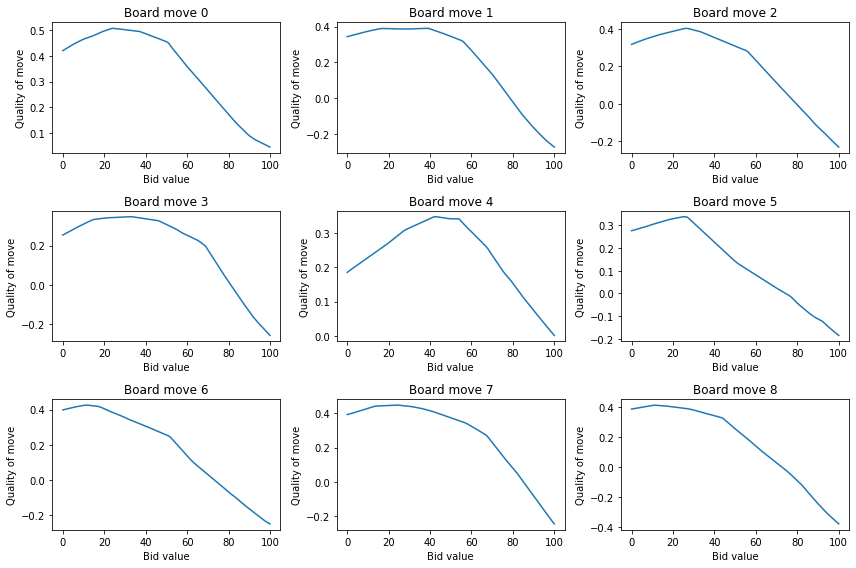

Animation of critic values saved!
Episode #5100  |  Val. Score: +0.20   |  Avg. Val. Score: -0.03  |  Epsilon: 0.682
                  Actor Loss: -1.447  |  Critic Loss: +0.446     |  Time Elapsed: 2446.51s
Episode #5200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.02  |  Epsilon: 0.677
                  Actor Loss: -1.437  |  Critic Loss: +0.485     |  Time Elapsed: 2502.07s
Episode #5300  |  Val. Score: -0.10   |  Avg. Val. Score: -0.01  |  Epsilon: 0.672
                  Actor Loss: -1.423  |  Critic Loss: +0.520     |  Time Elapsed: 2557.71s
Episode #5400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.06  |  Epsilon: 0.667
                  Actor Loss: -1.450  |  Critic Loss: +0.508     |  Time Elapsed: 2614.31s
Episode #5500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.12  |  Epsilon: 0.662
                  Actor Loss: -1.443  |  Critic Loss: +0.484     |  Time Elapsed: 2669.39s
Checkpoint saved!
Episode #5600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.16  |  Epsilon: 0

Episode #9700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.38  |  Epsilon: 0.483
                  Actor Loss: -1.589  |  Critic Loss: +0.597     |  Time Elapsed: 4858.85s
Episode #9800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.42  |  Epsilon: 0.479
                  Actor Loss: -1.600  |  Critic Loss: +0.514     |  Time Elapsed: 4912.43s
Episode #9900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.42  |  Epsilon: 0.476
                  Actor Loss: -1.622  |  Critic Loss: +0.476     |  Time Elapsed: 4967.35s
Episode #10000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.43  |  Epsilon: 0.472
                  Actor Loss: -1.644  |  Critic Loss: +0.478     |  Time Elapsed: 5022.84s
Checkpoint saved!


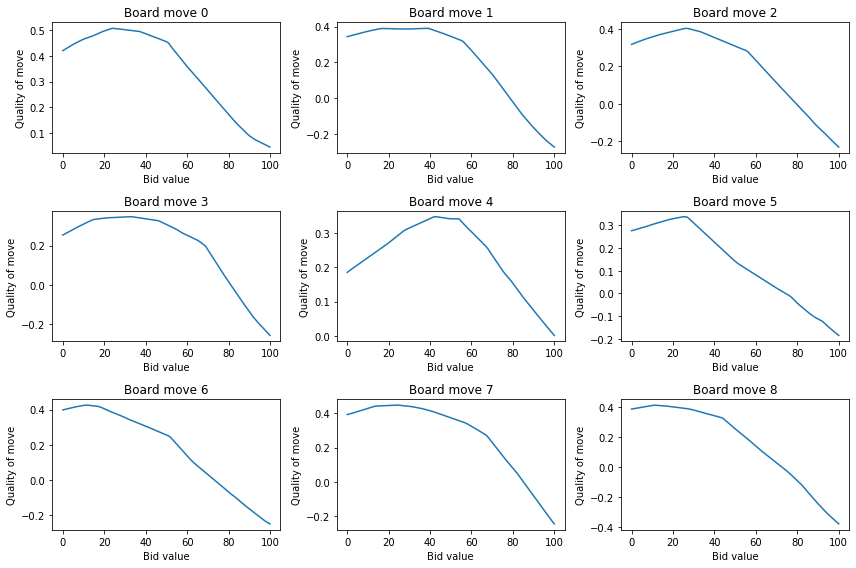

Animation of critic values saved!
Episode #10100  |  Val. Score: +0.30   |  Avg. Val. Score: +0.38  |  Epsilon: 0.469
                  Actor Loss: -1.581  |  Critic Loss: +0.530     |  Time Elapsed: 5087.72s
Episode #10200  |  Val. Score: +0.20   |  Avg. Val. Score: +0.36  |  Epsilon: 0.465
                  Actor Loss: -1.564  |  Critic Loss: +0.551     |  Time Elapsed: 5144.81s
Episode #10300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.38  |  Epsilon: 0.462
                  Actor Loss: -1.522  |  Critic Loss: +0.595     |  Time Elapsed: 5195.90s
Episode #10400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.44  |  Epsilon: 0.458
                  Actor Loss: -1.544  |  Critic Loss: +0.527     |  Time Elapsed: 5250.69s
Episode #10500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.44  |  Epsilon: 0.455
                  Actor Loss: -1.541  |  Critic Loss: +0.511     |  Time Elapsed: 5301.46s
Checkpoint saved!
Episode #10600  |  Val. Score: +0.20   |  Avg. Val. Score: +0.42  |  Epsi

Episode #14700  |  Val. Score: +0.30   |  Avg. Val. Score: +0.43  |  Epsilon: 0.332
                  Actor Loss: -1.604  |  Critic Loss: +0.526     |  Time Elapsed: 7592.17s
Episode #14800  |  Val. Score: +0.20   |  Avg. Val. Score: +0.40  |  Epsilon: 0.330
                  Actor Loss: -1.566  |  Critic Loss: +0.589     |  Time Elapsed: 7645.78s
Episode #14900  |  Val. Score: +0.30   |  Avg. Val. Score: +0.39  |  Epsilon: 0.327
                  Actor Loss: -1.571  |  Critic Loss: +0.479     |  Time Elapsed: 7702.05s
Episode #15000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.39  |  Epsilon: 0.325
                  Actor Loss: -1.552  |  Critic Loss: +0.549     |  Time Elapsed: 7759.50s
Checkpoint saved!


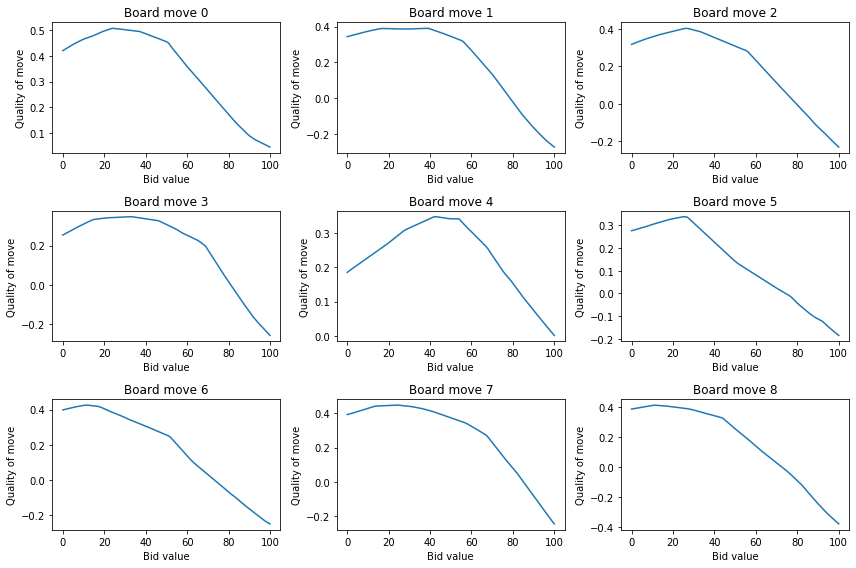

Animation of critic values saved!
Episode #15100  |  Val. Score: +0.30   |  Avg. Val. Score: +0.36  |  Epsilon: 0.322
                  Actor Loss: -1.568  |  Critic Loss: +0.487     |  Time Elapsed: 7823.50s
Episode #15200  |  Val. Score: +0.40   |  Avg. Val. Score: +0.36  |  Epsilon: 0.320
                  Actor Loss: -1.549  |  Critic Loss: +0.515     |  Time Elapsed: 7877.01s
Episode #15300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.36  |  Epsilon: 0.317
                  Actor Loss: -1.551  |  Critic Loss: +0.511     |  Time Elapsed: 7930.13s
Episode #15400  |  Val. Score: +0.00   |  Avg. Val. Score: +0.38  |  Epsilon: 0.315
                  Actor Loss: -1.568  |  Critic Loss: +0.481     |  Time Elapsed: 7979.65s
Episode #15500  |  Val. Score: +0.30   |  Avg. Val. Score: +0.35  |  Epsilon: 0.313
                  Actor Loss: -1.510  |  Critic Loss: +0.523     |  Time Elapsed: 8028.74s
Checkpoint saved!
Episode #15600  |  Val. Score: +0.30   |  Avg. Val. Score: +0.34  |  Epsi

Episode #19700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.47  |  Epsilon: 0.228
                  Actor Loss: -1.495  |  Critic Loss: +0.529     |  Time Elapsed: 10002.98s
Episode #19800  |  Val. Score: +0.20   |  Avg. Val. Score: +0.47  |  Epsilon: 0.226
                  Actor Loss: -1.468  |  Critic Loss: +0.509     |  Time Elapsed: 10049.48s
Episode #19900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.51  |  Epsilon: 0.225
                  Actor Loss: -1.499  |  Critic Loss: +0.520     |  Time Elapsed: 10096.84s
Episode #20000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.52  |  Epsilon: 0.223
                  Actor Loss: -1.513  |  Critic Loss: +0.487     |  Time Elapsed: 10144.82s
Checkpoint saved!


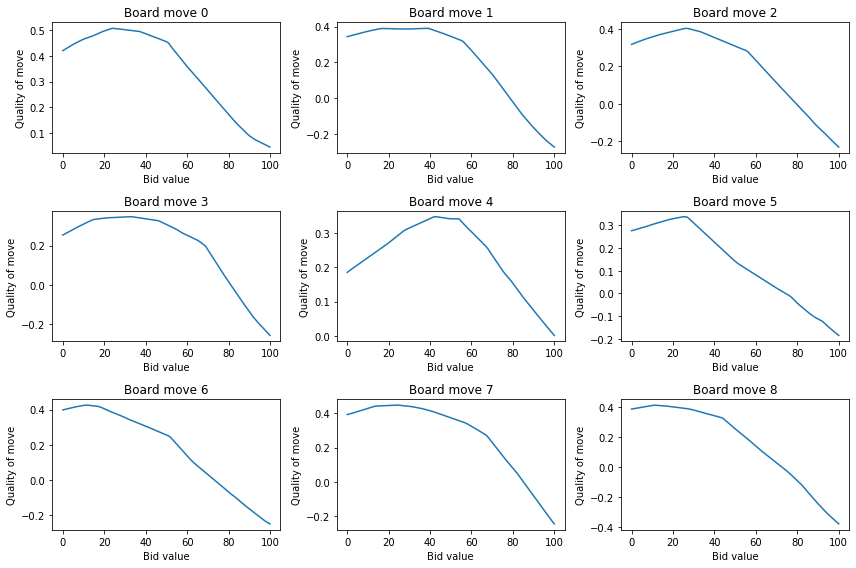

Animation of critic values saved!
Episode #20100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.55  |  Epsilon: 0.221
                  Actor Loss: -1.509  |  Critic Loss: +0.450     |  Time Elapsed: 10202.95s
Episode #20200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.61  |  Epsilon: 0.220
                  Actor Loss: -1.512  |  Critic Loss: +0.542     |  Time Elapsed: 10250.11s
Episode #20300  |  Val. Score: +0.10   |  Avg. Val. Score: +0.56  |  Epsilon: 0.218
                  Actor Loss: -1.542  |  Critic Loss: +0.487     |  Time Elapsed: 10300.88s
Episode #20400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.57  |  Epsilon: 0.217
                  Actor Loss: -1.513  |  Critic Loss: +0.481     |  Time Elapsed: 10347.54s
Episode #20500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.59  |  Epsilon: 0.215
                  Actor Loss: -1.540  |  Critic Loss: +0.520     |  Time Elapsed: 10395.47s
Checkpoint saved!
Episode #20600  |  Val. Score: +0.50   |  Avg. Val. Score: +0.58  | 

Episode #24700  |  Val. Score: +0.20   |  Avg. Val. Score: +0.63  |  Epsilon: 0.157
                  Actor Loss: -1.468  |  Critic Loss: +0.423     |  Time Elapsed: 12375.68s
Episode #24800  |  Val. Score: +0.30   |  Avg. Val. Score: +0.61  |  Epsilon: 0.156
                  Actor Loss: -1.459  |  Critic Loss: +0.429     |  Time Elapsed: 12423.41s
Episode #24900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.60  |  Epsilon: 0.154
                  Actor Loss: -1.456  |  Critic Loss: +0.441     |  Time Elapsed: 12470.36s
Episode #25000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.62  |  Epsilon: 0.153
                  Actor Loss: -1.532  |  Critic Loss: +0.436     |  Time Elapsed: 12516.36s
Checkpoint saved!


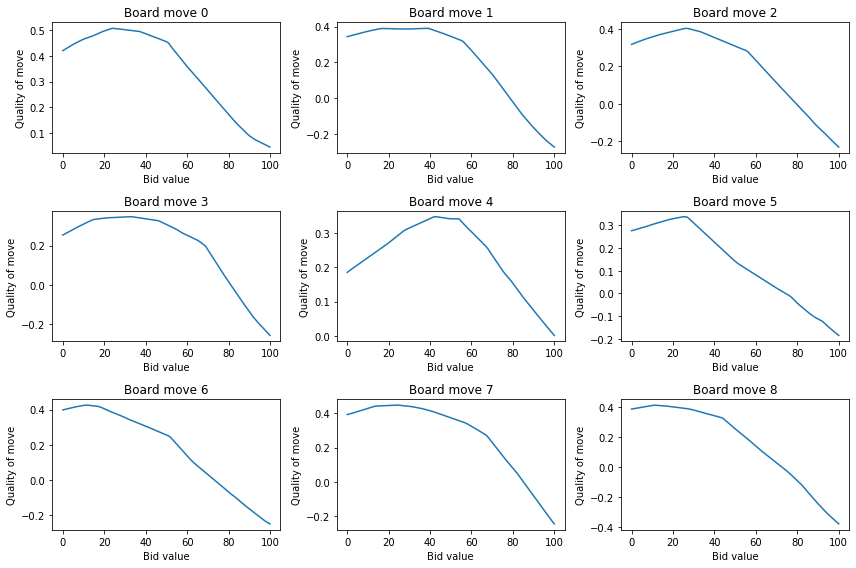

Animation of critic values saved!
Episode #25100  |  Val. Score: +0.00   |  Avg. Val. Score: +0.55  |  Epsilon: 0.152
                  Actor Loss: -1.435  |  Critic Loss: +0.422     |  Time Elapsed: 12578.84s
Episode #25200  |  Val. Score: +0.30   |  Avg. Val. Score: +0.50  |  Epsilon: 0.151
                  Actor Loss: -1.455  |  Critic Loss: +0.389     |  Time Elapsed: 12629.47s
Episode #25300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.48  |  Epsilon: 0.150
                  Actor Loss: -1.438  |  Critic Loss: +0.442     |  Time Elapsed: 12679.63s
Episode #25400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.48  |  Epsilon: 0.149
                  Actor Loss: -1.460  |  Critic Loss: +0.496     |  Time Elapsed: 12725.53s
Episode #25500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.54  |  Epsilon: 0.148
                  Actor Loss: -1.490  |  Critic Loss: +0.465     |  Time Elapsed: 12770.26s
Checkpoint saved!
Episode #25600  |  Val. Score: +0.20   |  Avg. Val. Score: +0.48  | 

Episode #29700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.50  |  Epsilon: 0.108
                  Actor Loss: -1.410  |  Critic Loss: +0.406     |  Time Elapsed: 14771.96s
Episode #29800  |  Val. Score: +0.30   |  Avg. Val. Score: +0.50  |  Epsilon: 0.107
                  Actor Loss: -1.358  |  Critic Loss: +0.460     |  Time Elapsed: 14817.12s
Episode #29900  |  Val. Score: +0.40   |  Avg. Val. Score: +0.53  |  Epsilon: 0.106
                  Actor Loss: -1.383  |  Critic Loss: +0.414     |  Time Elapsed: 14862.28s
Episode #30000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.54  |  Epsilon: 0.105
                  Actor Loss: -1.340  |  Critic Loss: +0.405     |  Time Elapsed: 14907.35s
Checkpoint saved!


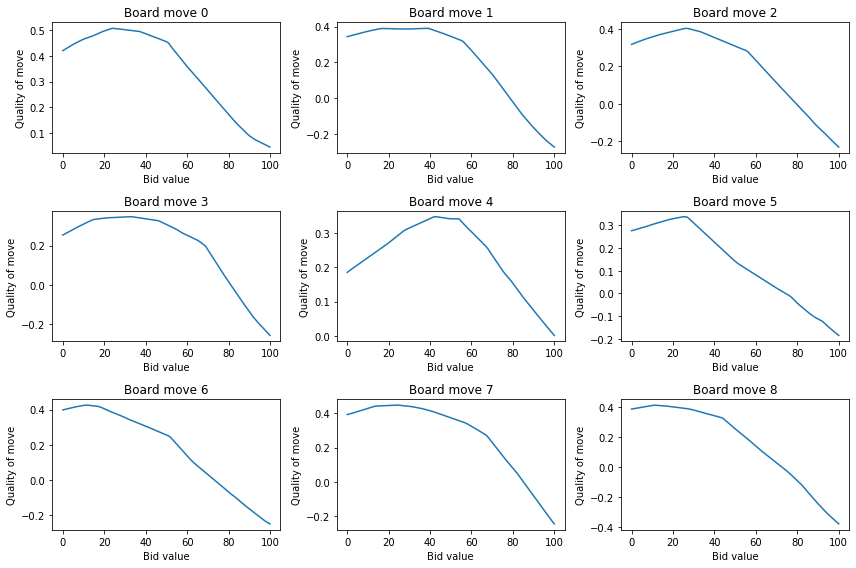

Animation of critic values saved!
Episode #30100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.54  |  Epsilon: 0.105
                  Actor Loss: -1.399  |  Critic Loss: +0.410     |  Time Elapsed: 14966.06s
Episode #30200  |  Val. Score: +0.10   |  Avg. Val. Score: +0.49  |  Epsilon: 0.104
                  Actor Loss: -1.357  |  Critic Loss: +0.453     |  Time Elapsed: 15010.92s
Episode #30300  |  Val. Score: +0.50   |  Avg. Val. Score: +0.46  |  Epsilon: 0.103
                  Actor Loss: -1.393  |  Critic Loss: +0.419     |  Time Elapsed: 15057.39s
Episode #30400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.48  |  Epsilon: 0.102
                  Actor Loss: -1.382  |  Critic Loss: +0.368     |  Time Elapsed: 15101.67s
Episode #30500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.48  |  Epsilon: 0.102
                  Actor Loss: -1.381  |  Critic Loss: +0.441     |  Time Elapsed: 15146.78s
Checkpoint saved!
Episode #30600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.49  | 

Episode #34700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.59  |  Epsilon: 0.074
                  Actor Loss: -1.305  |  Critic Loss: +0.376     |  Time Elapsed: 17195.45s
Episode #34800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.57  |  Epsilon: 0.074
                  Actor Loss: -1.313  |  Critic Loss: +0.395     |  Time Elapsed: 17244.26s
Episode #34900  |  Val. Score: +0.40   |  Avg. Val. Score: +0.53  |  Epsilon: 0.073
                  Actor Loss: -1.302  |  Critic Loss: +0.357     |  Time Elapsed: 17292.29s
Episode #35000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.54  |  Epsilon: 0.072
                  Actor Loss: -1.298  |  Critic Loss: +0.382     |  Time Elapsed: 17339.79s
Checkpoint saved!


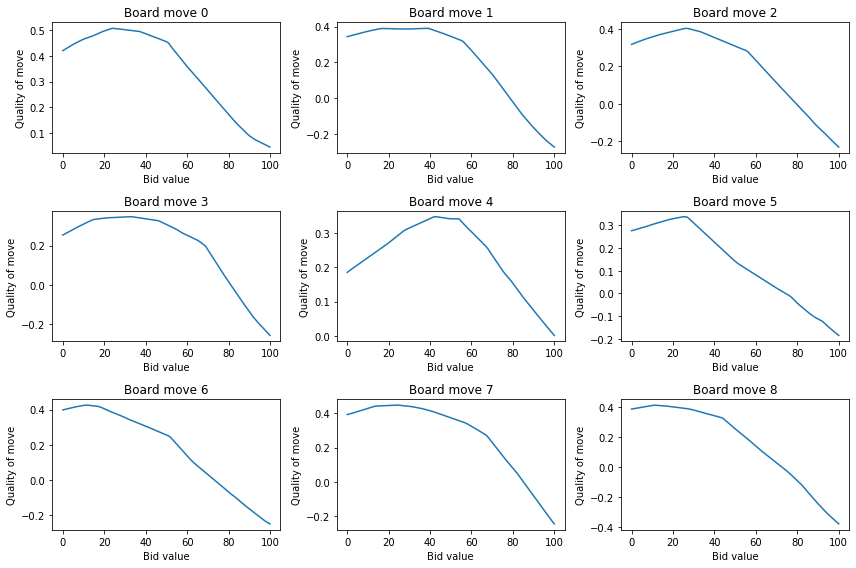

Animation of critic values saved!
Episode #35100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.51  |  Epsilon: 0.072
                  Actor Loss: -1.297  |  Critic Loss: +0.363     |  Time Elapsed: 17404.73s
Episode #35200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.55  |  Epsilon: 0.071
                  Actor Loss: -1.368  |  Critic Loss: +0.359     |  Time Elapsed: 17454.84s
Episode #35300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.59  |  Epsilon: 0.071
                  Actor Loss: -1.288  |  Critic Loss: +0.374     |  Time Elapsed: 17504.35s
Episode #35400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.62  |  Epsilon: 0.070
                  Actor Loss: -1.285  |  Critic Loss: +0.361     |  Time Elapsed: 17552.11s
Episode #35500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.62  |  Epsilon: 0.070
                  Actor Loss: -1.301  |  Critic Loss: +0.352     |  Time Elapsed: 17600.62s
Checkpoint saved!
Episode #35600  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  | 

Episode #39700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.051
                  Actor Loss: -1.269  |  Critic Loss: +0.325     |  Time Elapsed: 19663.81s
Episode #39800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.051
                  Actor Loss: -1.235  |  Critic Loss: +0.372     |  Time Elapsed: 19712.90s
Episode #39900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.050
                  Actor Loss: -1.284  |  Critic Loss: +0.354     |  Time Elapsed: 19764.63s
Episode #40000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.81  |  Epsilon: 0.050
                  Actor Loss: -1.266  |  Critic Loss: +0.349     |  Time Elapsed: 19815.86s
Checkpoint saved!


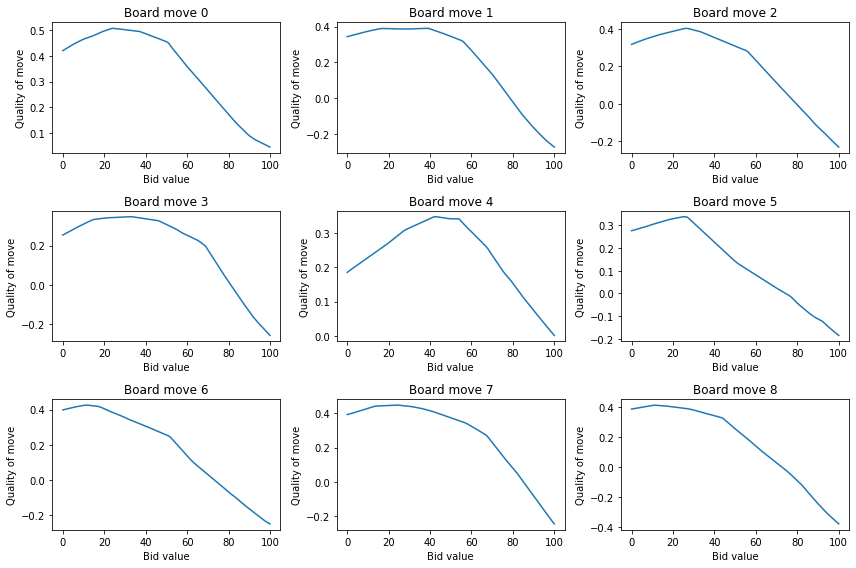

Animation of critic values saved!
Episode #40100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.049
                  Actor Loss: -1.266  |  Critic Loss: +0.353     |  Time Elapsed: 19880.26s
Episode #40200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.049
                  Actor Loss: -1.284  |  Critic Loss: +0.358     |  Time Elapsed: 19926.85s
Episode #40300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.89  |  Epsilon: 0.049
                  Actor Loss: -1.309  |  Critic Loss: +0.347     |  Time Elapsed: 19977.81s
Episode #40400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.048
                  Actor Loss: -1.260  |  Critic Loss: +0.359     |  Time Elapsed: 20028.43s
Episode #40500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.048
                  Actor Loss: -1.279  |  Critic Loss: +0.385     |  Time Elapsed: 20077.95s
Checkpoint saved!
Episode #40600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.83  | 

Episode #44700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.65  |  Epsilon: 0.035
                  Actor Loss: -1.207  |  Critic Loss: +0.323     |  Time Elapsed: 22193.93s
Episode #44800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.63  |  Epsilon: 0.035
                  Actor Loss: -1.218  |  Critic Loss: +0.366     |  Time Elapsed: 22244.85s
Episode #44900  |  Val. Score: +0.50   |  Avg. Val. Score: +0.62  |  Epsilon: 0.034
                  Actor Loss: -1.228  |  Critic Loss: +0.358     |  Time Elapsed: 22296.78s
Episode #45000  |  Val. Score: +0.90   |  Avg. Val. Score: +0.66  |  Epsilon: 0.034
                  Actor Loss: -1.244  |  Critic Loss: +0.299     |  Time Elapsed: 22348.57s
Checkpoint saved!


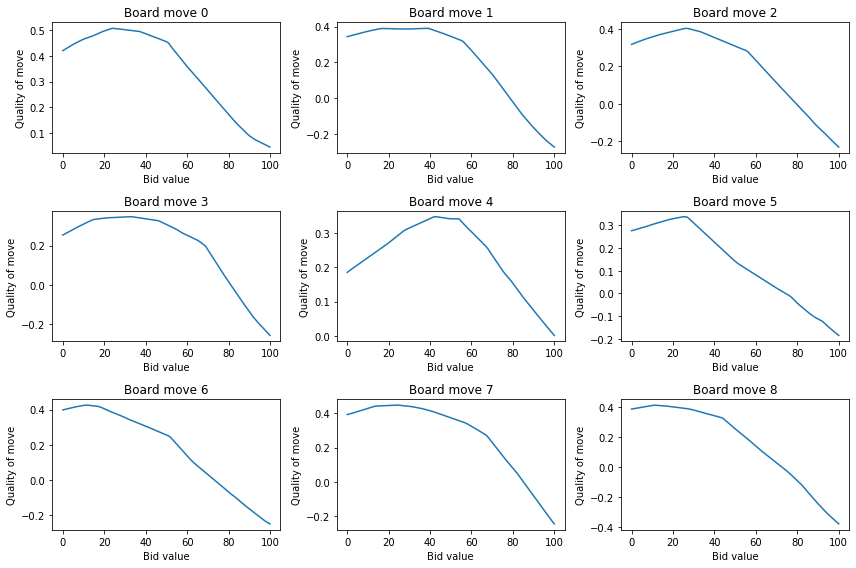

Animation of critic values saved!
Episode #45100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.68  |  Epsilon: 0.034
                  Actor Loss: -1.223  |  Critic Loss: +0.335     |  Time Elapsed: 22417.34s
Episode #45200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.66  |  Epsilon: 0.034
                  Actor Loss: -1.208  |  Critic Loss: +0.341     |  Time Elapsed: 22469.77s
Episode #45300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.64  |  Epsilon: 0.033
                  Actor Loss: -1.232  |  Critic Loss: +0.331     |  Time Elapsed: 22520.74s
Episode #45400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.70  |  Epsilon: 0.033
                  Actor Loss: -1.189  |  Critic Loss: +0.355     |  Time Elapsed: 22569.02s
Episode #45500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  |  Epsilon: 0.033
                  Actor Loss: -1.188  |  Critic Loss: +0.344     |  Time Elapsed: 22621.46s
Checkpoint saved!
Episode #45600  |  Val. Score: +0.00   |  Avg. Val. Score: +0.65  | 

Episode #49700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.71  |  Epsilon: 0.024
                  Actor Loss: -1.175  |  Critic Loss: +0.302     |  Time Elapsed: 24765.07s
Episode #49800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.67  |  Epsilon: 0.024
                  Actor Loss: -1.134  |  Critic Loss: +0.317     |  Time Elapsed: 24814.57s
Episode #49900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.024
                  Actor Loss: -1.191  |  Critic Loss: +0.306     |  Time Elapsed: 24866.67s
Episode #50000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.024
                  Actor Loss: -1.140  |  Critic Loss: +0.324     |  Time Elapsed: 24919.97s
Checkpoint saved!


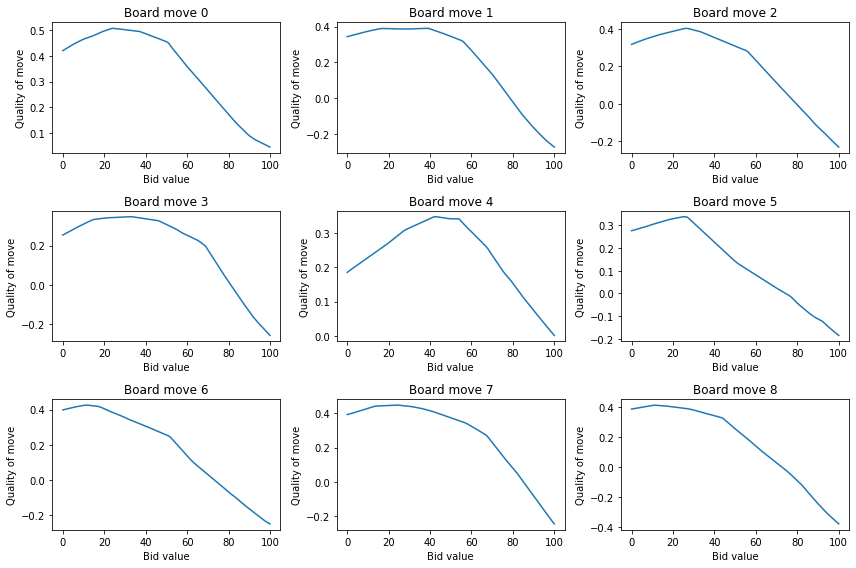

Animation of critic values saved!
Episode #50100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.67  |  Epsilon: 0.023
                  Actor Loss: -1.157  |  Critic Loss: +0.301     |  Time Elapsed: 24991.98s
Episode #50200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.023
                  Actor Loss: -1.159  |  Critic Loss: +0.305     |  Time Elapsed: 25043.34s
Episode #50300  |  Val. Score: +0.50   |  Avg. Val. Score: +0.72  |  Epsilon: 0.023
                  Actor Loss: -1.124  |  Critic Loss: +0.316     |  Time Elapsed: 25097.84s
Episode #50400  |  Val. Score: +0.50   |  Avg. Val. Score: +0.71  |  Epsilon: 0.023
                  Actor Loss: -1.193  |  Critic Loss: +0.291     |  Time Elapsed: 25147.30s
Episode #50500  |  Val. Score: +0.00   |  Avg. Val. Score: +0.65  |  Epsilon: 0.023
                  Actor Loss: -1.137  |  Critic Loss: +0.307     |  Time Elapsed: 25197.17s
Checkpoint saved!
Episode #50600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.61  | 

Episode #54700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.68  |  Epsilon: 0.017
                  Actor Loss: -1.199  |  Critic Loss: +0.305     |  Time Elapsed: 27429.66s
Episode #54800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  |  Epsilon: 0.016
                  Actor Loss: -1.173  |  Critic Loss: +0.298     |  Time Elapsed: 27482.79s
Episode #54900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.71  |  Epsilon: 0.016
                  Actor Loss: -1.189  |  Critic Loss: +0.291     |  Time Elapsed: 27535.61s
Episode #55000  |  Val. Score: +0.90   |  Avg. Val. Score: +0.73  |  Epsilon: 0.016
                  Actor Loss: -1.142  |  Critic Loss: +0.316     |  Time Elapsed: 27588.99s
Checkpoint saved!


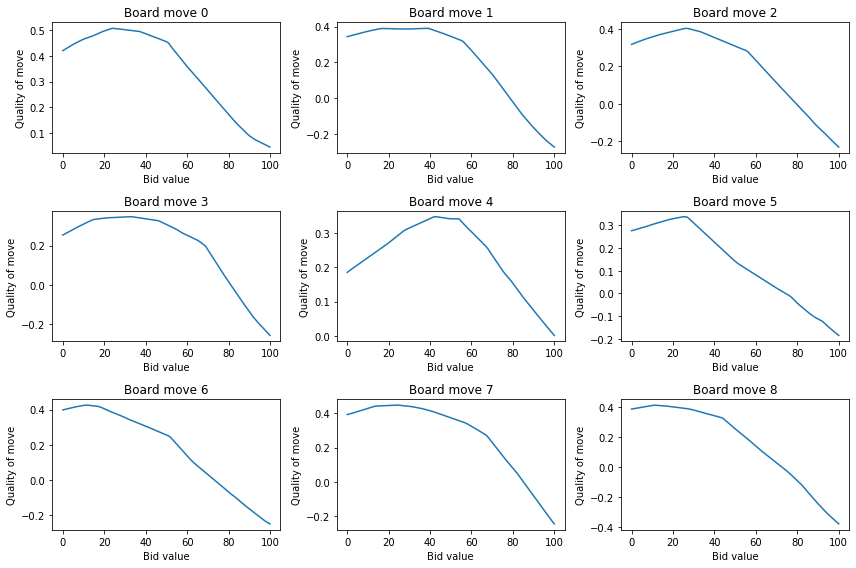

Animation of critic values saved!
Episode #55100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.016
                  Actor Loss: -1.199  |  Critic Loss: +0.334     |  Time Elapsed: 27666.33s
Episode #55200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.74  |  Epsilon: 0.016
                  Actor Loss: -1.190  |  Critic Loss: +0.304     |  Time Elapsed: 27718.27s
Episode #55300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.73  |  Epsilon: 0.016
                  Actor Loss: -1.180  |  Critic Loss: +0.315     |  Time Elapsed: 27770.46s
Episode #55400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.73  |  Epsilon: 0.016
                  Actor Loss: -1.174  |  Critic Loss: +0.300     |  Time Elapsed: 27825.45s
Episode #55500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.77  |  Epsilon: 0.016
                  Actor Loss: -1.168  |  Critic Loss: +0.293     |  Time Elapsed: 27878.60s
Checkpoint saved!
Episode #55600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  | 

Episode #59700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.68  |  Epsilon: 0.011
                  Actor Loss: -1.138  |  Critic Loss: +0.302     |  Time Elapsed: 30079.51s
Episode #59800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.72  |  Epsilon: 0.011
                  Actor Loss: -1.154  |  Critic Loss: +0.303     |  Time Elapsed: 30133.06s
Episode #59900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.74  |  Epsilon: 0.011
                  Actor Loss: -1.150  |  Critic Loss: +0.343     |  Time Elapsed: 30186.00s
Episode #60000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.73  |  Epsilon: 0.011
                  Actor Loss: -1.185  |  Critic Loss: +0.324     |  Time Elapsed: 30239.01s
Checkpoint saved!


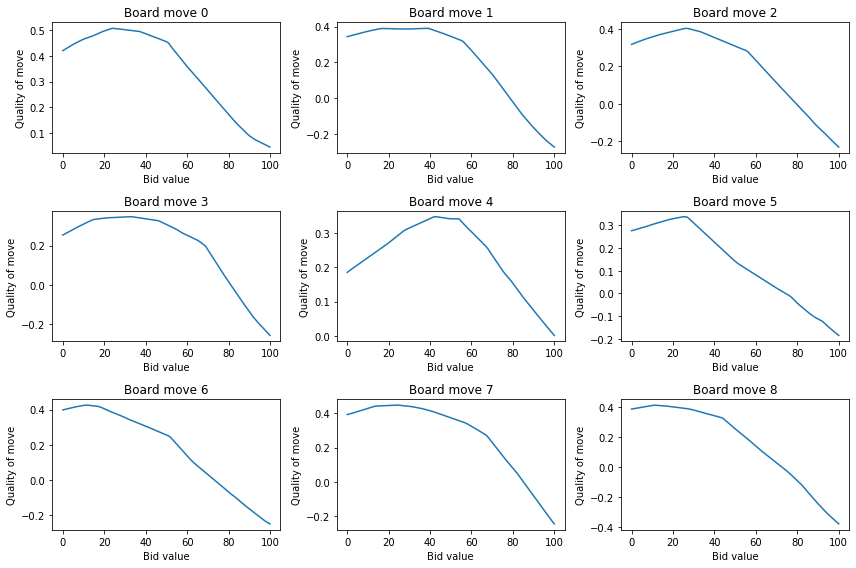

Animation of critic values saved!
Episode #60100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.76  |  Epsilon: 0.011
                  Actor Loss: -1.209  |  Critic Loss: +0.348     |  Time Elapsed: 30317.51s
Episode #60200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.011
                  Actor Loss: -1.158  |  Critic Loss: +0.310     |  Time Elapsed: 30369.28s
Episode #60300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.011
                  Actor Loss: -1.182  |  Critic Loss: +0.336     |  Time Elapsed: 30423.66s
Episode #60400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.011
                  Actor Loss: -1.208  |  Critic Loss: +0.309     |  Time Elapsed: 30479.60s
Episode #60500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.011
                  Actor Loss: -1.194  |  Critic Loss: +0.336     |  Time Elapsed: 30533.73s
Checkpoint saved!
Episode #60600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.77  | 

Episode #64700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.67  |  Epsilon: 0.010
                  Actor Loss: -1.164  |  Critic Loss: +0.318     |  Time Elapsed: 32856.24s
Episode #64800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.69  |  Epsilon: 0.010
                  Actor Loss: -1.156  |  Critic Loss: +0.384     |  Time Elapsed: 32912.36s
Episode #64900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.010
                  Actor Loss: -1.151  |  Critic Loss: +0.366     |  Time Elapsed: 32970.92s
Episode #65000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -1.197  |  Critic Loss: +0.308     |  Time Elapsed: 33024.40s
Checkpoint saved!


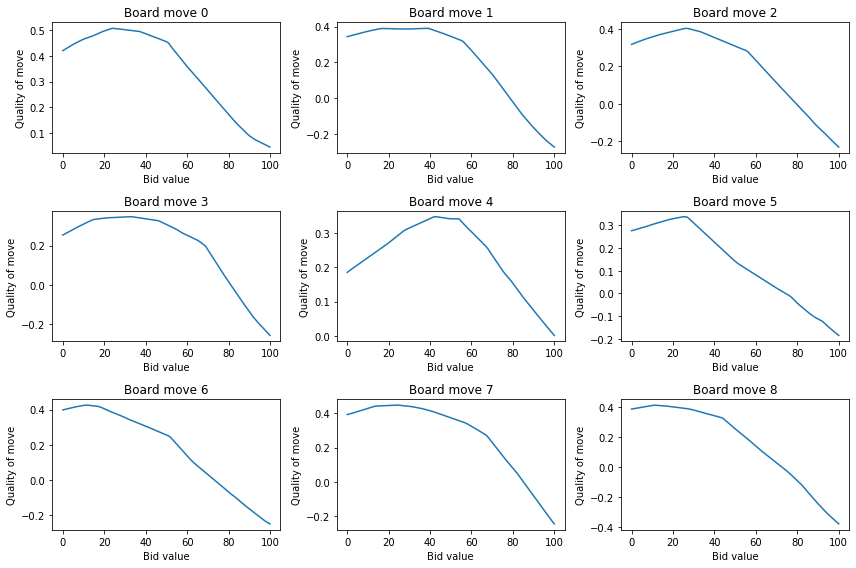

Animation of critic values saved!
Episode #65100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.73  |  Epsilon: 0.010
                  Actor Loss: -1.171  |  Critic Loss: +0.286     |  Time Elapsed: 33108.66s
Episode #65200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.70  |  Epsilon: 0.010
                  Actor Loss: -1.161  |  Critic Loss: +0.304     |  Time Elapsed: 33165.09s
Episode #65300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.68  |  Epsilon: 0.010
                  Actor Loss: -1.170  |  Critic Loss: +0.313     |  Time Elapsed: 33220.42s
Episode #65400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.67  |  Epsilon: 0.010
                  Actor Loss: -1.168  |  Critic Loss: +0.288     |  Time Elapsed: 33276.37s
Episode #65500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.64  |  Epsilon: 0.010
                  Actor Loss: -1.152  |  Critic Loss: +0.290     |  Time Elapsed: 33329.75s
Checkpoint saved!
Episode #65600  |  Val. Score: +0.00   |  Avg. Val. Score: +0.62  | 

Episode #69700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -1.074  |  Critic Loss: +0.297     |  Time Elapsed: 35694.93s
Episode #69800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -1.088  |  Critic Loss: +0.275     |  Time Elapsed: 35752.19s
Episode #69900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -1.081  |  Critic Loss: +0.303     |  Time Elapsed: 35808.27s
Episode #70000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -1.088  |  Critic Loss: +0.286     |  Time Elapsed: 35861.61s
Checkpoint saved!


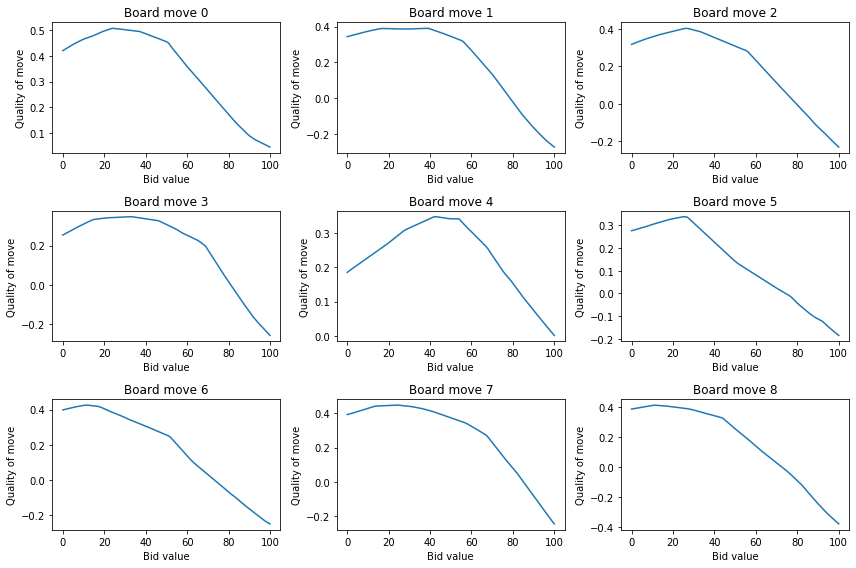

Animation of critic values saved!
Episode #70100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -1.087  |  Critic Loss: +0.258     |  Time Elapsed: 35947.79s
Episode #70200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.71  |  Epsilon: 0.010
                  Actor Loss: -1.056  |  Critic Loss: +0.273     |  Time Elapsed: 36003.87s
Episode #70300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.70  |  Epsilon: 0.010
                  Actor Loss: -1.083  |  Critic Loss: +0.273     |  Time Elapsed: 36058.10s
Episode #70400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -1.086  |  Critic Loss: +0.242     |  Time Elapsed: 36115.14s
Episode #70500  |  Val. Score: +0.50   |  Avg. Val. Score: +0.73  |  Epsilon: 0.010
                  Actor Loss: -1.039  |  Critic Loss: +0.299     |  Time Elapsed: 36172.93s
Checkpoint saved!
Episode #70600  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  | 

Episode #74700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.70  |  Epsilon: 0.010
                  Actor Loss: -1.033  |  Critic Loss: +0.259     |  Time Elapsed: 38613.91s
Episode #74800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -1.041  |  Critic Loss: +0.268     |  Time Elapsed: 38671.46s
Episode #74900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.72  |  Epsilon: 0.010
                  Actor Loss: -1.031  |  Critic Loss: +0.268     |  Time Elapsed: 38731.57s
Episode #75000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -1.039  |  Critic Loss: +0.300     |  Time Elapsed: 38790.55s
Checkpoint saved!


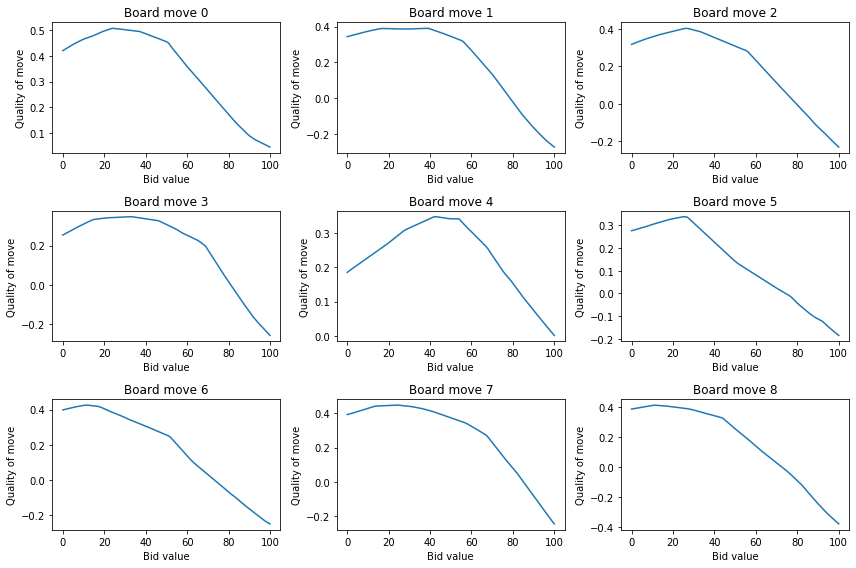

Animation of critic values saved!
Episode #75100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -1.054  |  Critic Loss: +0.259     |  Time Elapsed: 38884.11s
Episode #75200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.73  |  Epsilon: 0.010
                  Actor Loss: -1.050  |  Critic Loss: +0.271     |  Time Elapsed: 38941.92s
Episode #75300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.69  |  Epsilon: 0.010
                  Actor Loss: -1.073  |  Critic Loss: +0.238     |  Time Elapsed: 39001.68s
Episode #75400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.69  |  Epsilon: 0.010
                  Actor Loss: -1.048  |  Critic Loss: +0.249     |  Time Elapsed: 39060.56s
Episode #75500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.67  |  Epsilon: 0.010
                  Actor Loss: -1.041  |  Critic Loss: +0.266     |  Time Elapsed: 39119.42s
Checkpoint saved!
Episode #75600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.72  | 

Episode #79700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.67  |  Epsilon: 0.010
                  Actor Loss: -1.099  |  Critic Loss: +0.272     |  Time Elapsed: 41626.58s
Episode #79800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.63  |  Epsilon: 0.010
                  Actor Loss: -1.086  |  Critic Loss: +0.291     |  Time Elapsed: 41688.31s
Episode #79900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.61  |  Epsilon: 0.010
                  Actor Loss: -1.060  |  Critic Loss: +0.269     |  Time Elapsed: 41751.34s
Episode #80000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.60  |  Epsilon: 0.010
                  Actor Loss: -1.068  |  Critic Loss: +0.294     |  Time Elapsed: 41810.24s
Checkpoint saved!


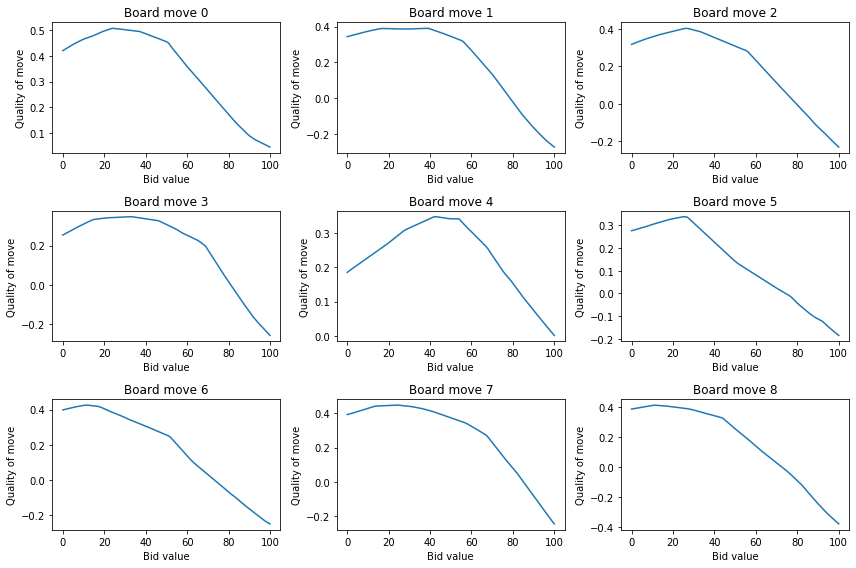

Animation of critic values saved!
Episode #80100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.66  |  Epsilon: 0.010
                  Actor Loss: -1.063  |  Critic Loss: +0.265     |  Time Elapsed: 41908.39s
Episode #80200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.68  |  Epsilon: 0.010
                  Actor Loss: -1.112  |  Critic Loss: +0.270     |  Time Elapsed: 41972.12s
Episode #80300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.71  |  Epsilon: 0.010
                  Actor Loss: -1.084  |  Critic Loss: +0.250     |  Time Elapsed: 42037.72s
Episode #80400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -1.049  |  Critic Loss: +0.255     |  Time Elapsed: 42101.49s
Episode #80500  |  Val. Score: +0.30   |  Avg. Val. Score: +0.73  |  Epsilon: 0.010
                  Actor Loss: -1.063  |  Critic Loss: +0.246     |  Time Elapsed: 42162.77s
Checkpoint saved!
Episode #80600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  | 

Episode #84700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.68  |  Epsilon: 0.010
                  Actor Loss: -0.992  |  Critic Loss: +0.271     |  Time Elapsed: 44804.21s
Episode #84800  |  Val. Score: +0.50   |  Avg. Val. Score: +0.63  |  Epsilon: 0.010
                  Actor Loss: -0.996  |  Critic Loss: +0.261     |  Time Elapsed: 44868.98s
Episode #84900  |  Val. Score: +0.50   |  Avg. Val. Score: +0.62  |  Epsilon: 0.010
                  Actor Loss: -0.995  |  Critic Loss: +0.240     |  Time Elapsed: 44932.40s
Episode #85000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.64  |  Epsilon: 0.010
                  Actor Loss: -0.999  |  Critic Loss: +0.241     |  Time Elapsed: 44996.02s
Checkpoint saved!


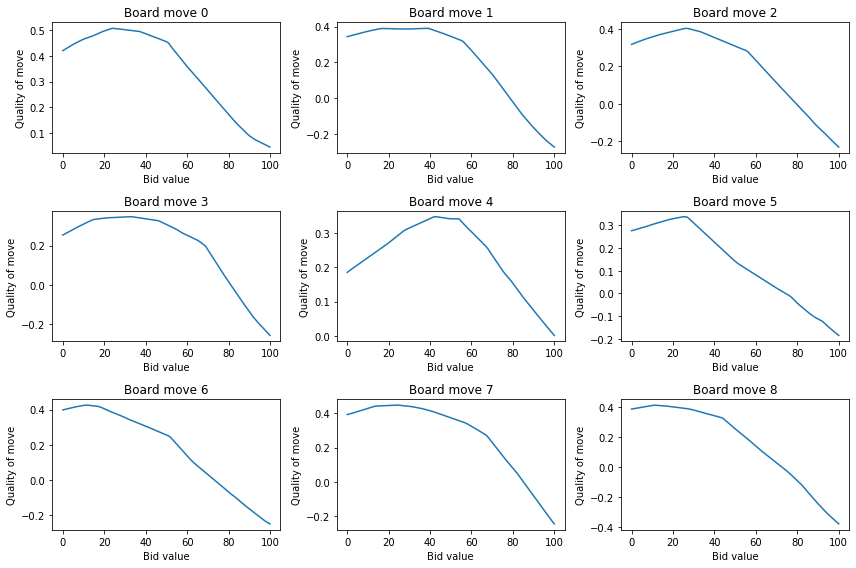

Animation of critic values saved!
Episode #85100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.66  |  Epsilon: 0.010
                  Actor Loss: -1.011  |  Critic Loss: +0.222     |  Time Elapsed: 45095.05s
Episode #85200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.66  |  Epsilon: 0.010
                  Actor Loss: -0.994  |  Critic Loss: +0.259     |  Time Elapsed: 45157.52s
Episode #85300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.010
                  Actor Loss: -1.022  |  Critic Loss: +0.232     |  Time Elapsed: 45223.67s
Episode #85400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.010
                  Actor Loss: -0.985  |  Critic Loss: +0.270     |  Time Elapsed: 45287.29s
Episode #85500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  |  Epsilon: 0.010
                  Actor Loss: -1.008  |  Critic Loss: +0.248     |  Time Elapsed: 45352.48s
Checkpoint saved!
Episode #85600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  | 

Episode #89700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.973  |  Critic Loss: +0.228     |  Time Elapsed: 48077.47s
Episode #89800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.970  |  Critic Loss: +0.226     |  Time Elapsed: 48141.18s
Episode #89900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.998  |  Critic Loss: +0.216     |  Time Elapsed: 48205.76s
Episode #90000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.987  |  Critic Loss: +0.211     |  Time Elapsed: 48272.32s
Checkpoint saved!


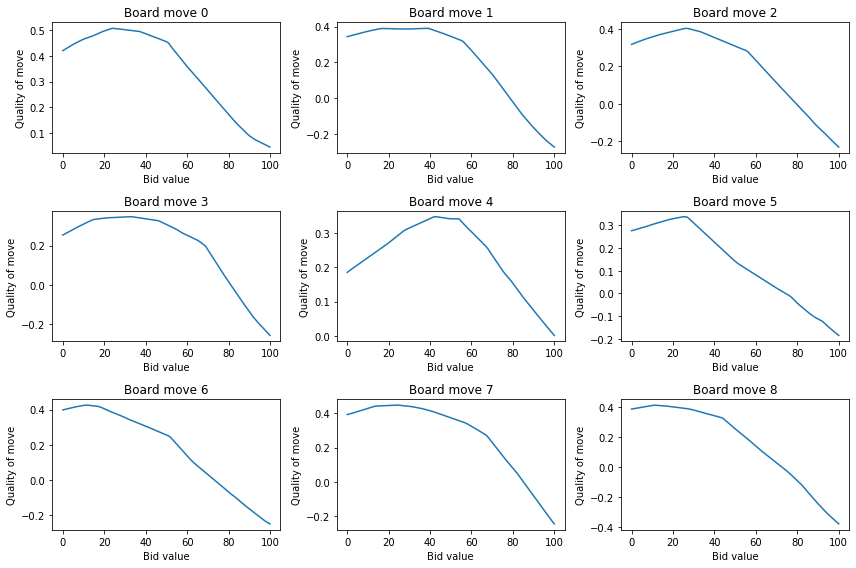

Animation of critic values saved!
Episode #90100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.974  |  Critic Loss: +0.203     |  Time Elapsed: 48379.65s
Episode #90200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.962  |  Critic Loss: +0.232     |  Time Elapsed: 48444.27s
Episode #90300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.974  |  Critic Loss: +0.253     |  Time Elapsed: 48510.23s
Episode #90400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -0.974  |  Critic Loss: +0.256     |  Time Elapsed: 48572.15s
Episode #90500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -0.972  |  Critic Loss: +0.244     |  Time Elapsed: 48637.57s
Checkpoint saved!
Episode #90600  |  Val. Score: +0.10   |  Avg. Val. Score: +0.70  | 

Episode #94700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.977  |  Critic Loss: +0.253     |  Time Elapsed: 51457.88s
Episode #94800  |  Val. Score: +0.90   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -1.000  |  Critic Loss: +0.243     |  Time Elapsed: 51525.56s
Episode #94900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.964  |  Critic Loss: +0.260     |  Time Elapsed: 51591.31s
Episode #95000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.963  |  Critic Loss: +0.272     |  Time Elapsed: 51659.31s
Checkpoint saved!


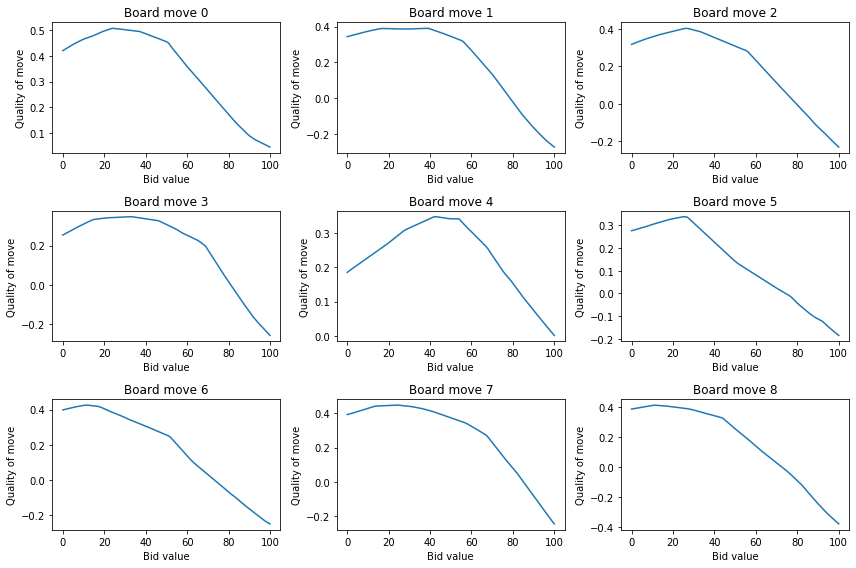

Animation of critic values saved!
Episode #95100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -1.003  |  Critic Loss: +0.229     |  Time Elapsed: 51763.83s
Episode #95200  |  Val. Score: +0.40   |  Avg. Val. Score: +0.70  |  Epsilon: 0.010
                  Actor Loss: -0.994  |  Critic Loss: +0.261     |  Time Elapsed: 51832.91s
Episode #95300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.70  |  Epsilon: 0.010
                  Actor Loss: -0.984  |  Critic Loss: +0.234     |  Time Elapsed: 51897.40s
Episode #95400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.66  |  Epsilon: 0.010
                  Actor Loss: -1.003  |  Critic Loss: +0.235     |  Time Elapsed: 51962.76s
Episode #95500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.63  |  Epsilon: 0.010
                  Actor Loss: -0.988  |  Critic Loss: +0.251     |  Time Elapsed: 52025.04s
Checkpoint saved!
Episode #95600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.65  | 

Episode #99700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.962  |  Critic Loss: +0.213     |  Time Elapsed: 54840.05s
Episode #99800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.963  |  Critic Loss: +0.210     |  Time Elapsed: 54906.27s
Episode #99900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.951  |  Critic Loss: +0.227     |  Time Elapsed: 54973.80s
Episode #100000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.972  |  Critic Loss: +0.227     |  Time Elapsed: 55040.87s
Checkpoint saved!


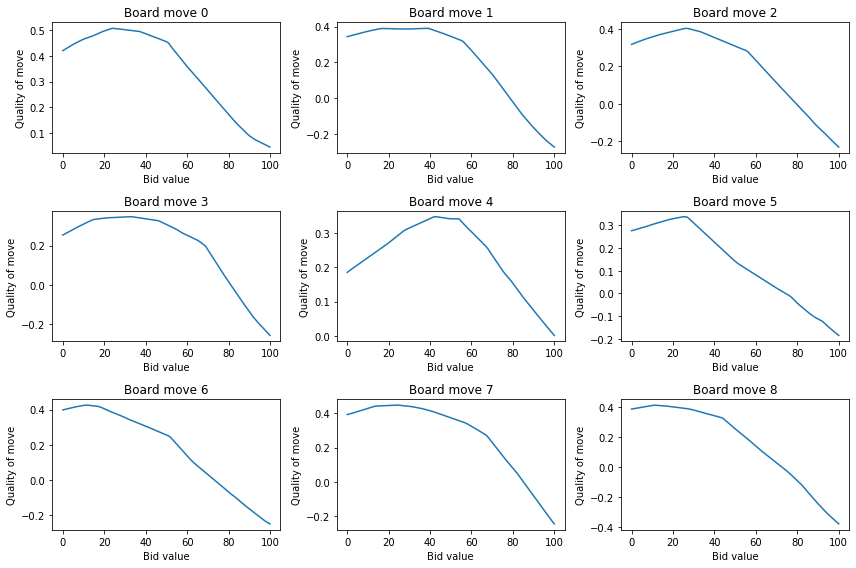

Animation of critic values saved!
Model saved!


In [11]:
n_episodes=100000
checkpoint_each=500
validate_each=100
n_episodes_validation=10
save_critic_value_each=1000
save_animation_each=5000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999925
players = [
    DRLPlayer(0, controller.game, drl_agent, train_mode=True),
]
if TRAIN_MODE == 'self_play':
    players.append(DRLPlayer(1, controller.game, drl_agent, train_mode=True))
elif TRAIN_MODE == 'random':
    players.append(RandomPlayer(1))
elif TRAIN_MODE == 'semi_random':
    players.append(SemiRandomPlayer(1, controller.game))
validation_scores, critic_values_by_episode = init_train(controller, players, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=n_episodes, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


In [12]:
len(critic_values_by_episode)

100

In [13]:
final_validation_scores = validation_scores
final_critic_values_by_episode = critic_values_by_episode

Episode #100100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.60  |  Epsilon: 0.010
                  Actor Loss: -0.972  |  Critic Loss: +0.229     |  Time Elapsed: 65.41s
Episode #100200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.80  |  Epsilon: 0.010
                  Actor Loss: -0.954  |  Critic Loss: +0.223     |  Time Elapsed: 132.46s
Episode #100300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.959  |  Critic Loss: +0.217     |  Time Elapsed: 197.41s
Episode #100400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -0.980  |  Critic Loss: +0.204     |  Time Elapsed: 259.07s
Episode #100500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.961  |  Critic Loss: +0.241     |  Time Elapsed: 323.04s
Checkpoint saved!
Episode #100600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor

Episode #104700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -0.943  |  Critic Loss: +0.250     |  Time Elapsed: 3104.06s
Episode #104800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.941  |  Critic Loss: +0.233     |  Time Elapsed: 3171.77s
Episode #104900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.953  |  Critic Loss: +0.230     |  Time Elapsed: 3237.11s
Episode #105000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.971  |  Critic Loss: +0.194     |  Time Elapsed: 3302.04s
Checkpoint saved!


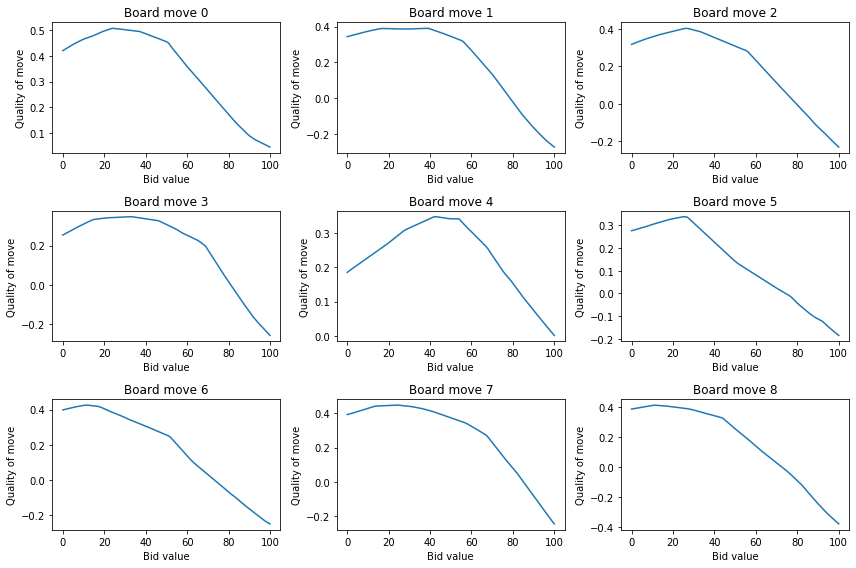

Animation of critic values saved!
Episode #105100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.950  |  Critic Loss: +0.228     |  Time Elapsed: 3413.91s
Episode #105200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.936  |  Critic Loss: +0.219     |  Time Elapsed: 3480.51s
Episode #105300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.949  |  Critic Loss: +0.247     |  Time Elapsed: 3547.86s
Episode #105400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.966  |  Critic Loss: +0.232     |  Time Elapsed: 3612.35s
Episode #105500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.957  |  Critic Loss: +0.240     |  Time Elapsed: 3676.69s
Checkpoint saved!
Episode #105600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.85  |

Episode #109700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.935  |  Critic Loss: +0.234     |  Time Elapsed: 6494.76s
Episode #109800  |  Val. Score: +0.90   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.930  |  Critic Loss: +0.217     |  Time Elapsed: 6564.26s
Episode #109900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.943  |  Critic Loss: +0.220     |  Time Elapsed: 6630.07s
Episode #110000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.929  |  Critic Loss: +0.236     |  Time Elapsed: 6697.13s
Checkpoint saved!


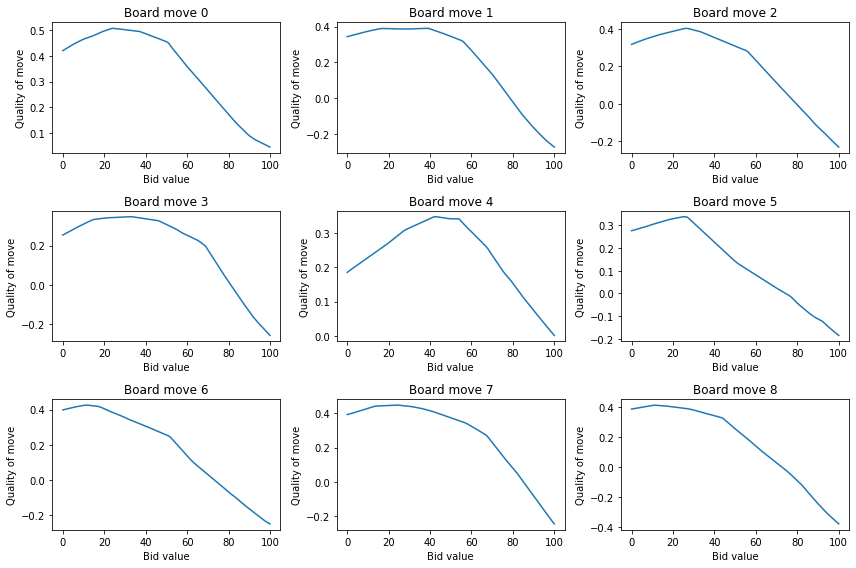

Animation of critic values saved!
Episode #110100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.932  |  Critic Loss: +0.222     |  Time Elapsed: 6817.24s
Episode #110200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.953  |  Critic Loss: +0.219     |  Time Elapsed: 6886.95s
Episode #110300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.948  |  Critic Loss: +0.216     |  Time Elapsed: 6960.32s
Episode #110400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.946  |  Critic Loss: +0.242     |  Time Elapsed: 7029.27s
Episode #110500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.903  |  Critic Loss: +0.229     |  Time Elapsed: 7105.18s
Checkpoint saved!
Episode #110600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |

Episode #114700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.927  |  Critic Loss: +0.248     |  Time Elapsed: 10281.35s
Episode #114800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.941  |  Critic Loss: +0.209     |  Time Elapsed: 10363.63s
Episode #114900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.947  |  Critic Loss: +0.221     |  Time Elapsed: 10446.98s
Episode #115000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.956  |  Critic Loss: +0.215     |  Time Elapsed: 10526.21s
Checkpoint saved!


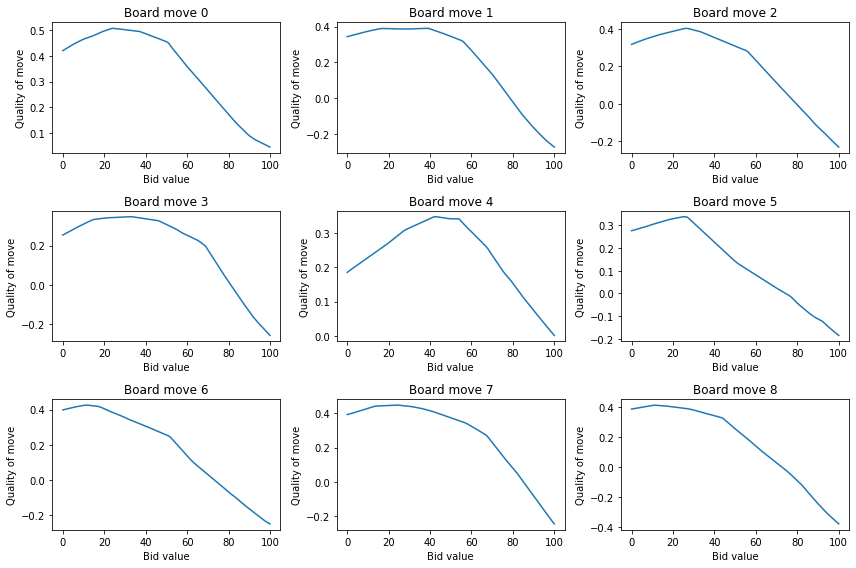

Animation of critic values saved!
Episode #115100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.941  |  Critic Loss: +0.228     |  Time Elapsed: 10655.27s
Episode #115200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.913  |  Critic Loss: +0.221     |  Time Elapsed: 10733.18s
Episode #115300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.940  |  Critic Loss: +0.222     |  Time Elapsed: 10815.75s
Episode #115400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.936  |  Critic Loss: +0.224     |  Time Elapsed: 10886.78s
Episode #115500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.923  |  Critic Loss: +0.222     |  Time Elapsed: 10964.71s
Checkpoint saved!
Episode #115600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.

Episode #119700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.990  |  Critic Loss: +0.221     |  Time Elapsed: 14521.74s
Episode #119800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.971  |  Critic Loss: +0.240     |  Time Elapsed: 14607.94s
Episode #119900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.967  |  Critic Loss: +0.245     |  Time Elapsed: 14693.69s
Episode #120000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.980  |  Critic Loss: +0.210     |  Time Elapsed: 14778.77s
Checkpoint saved!


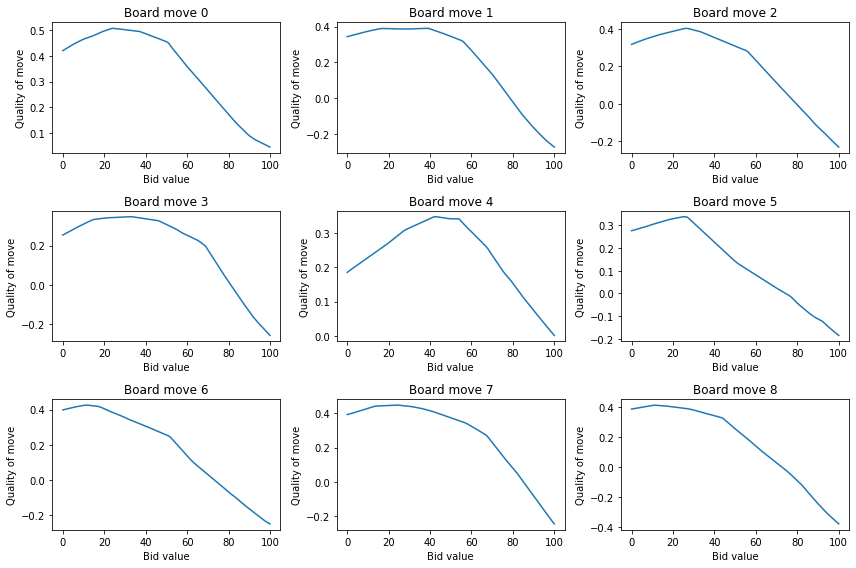

Animation of critic values saved!
Model saved!


In [26]:
# Continue training
validation_scores_continued, critic_values_by_episode_continued = init_train(controller, players,
                    start_epoch=100001, critic_values_by_episode=critic_values_by_episode, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=50000, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=0.01, eps_end=eps_end, eps_decay=eps_decay)

In [27]:
final_validation_scores += validation_scores_continued
final_critic_values_by_episode += critic_values_by_episode_continued

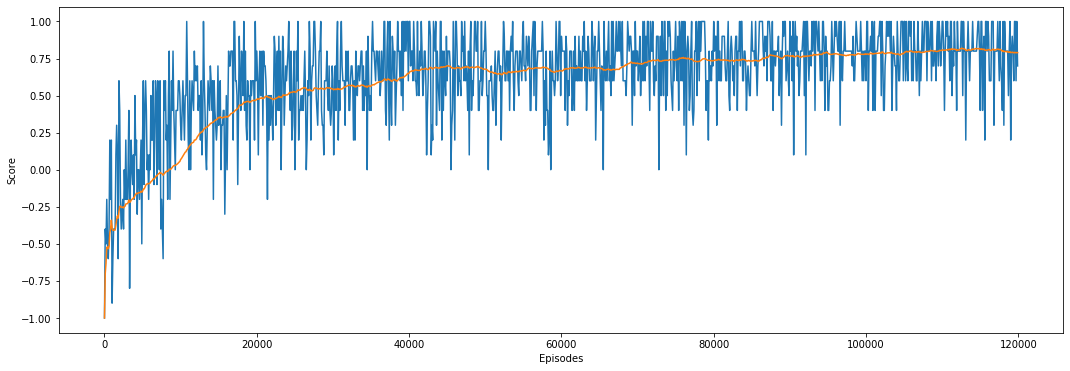

In [28]:
plot_scores(final_validation_scores, validate_each)

In [29]:
drl_agent.save_model(f'../checkpoints/{MODEL_VERSION}_model_final.pt')

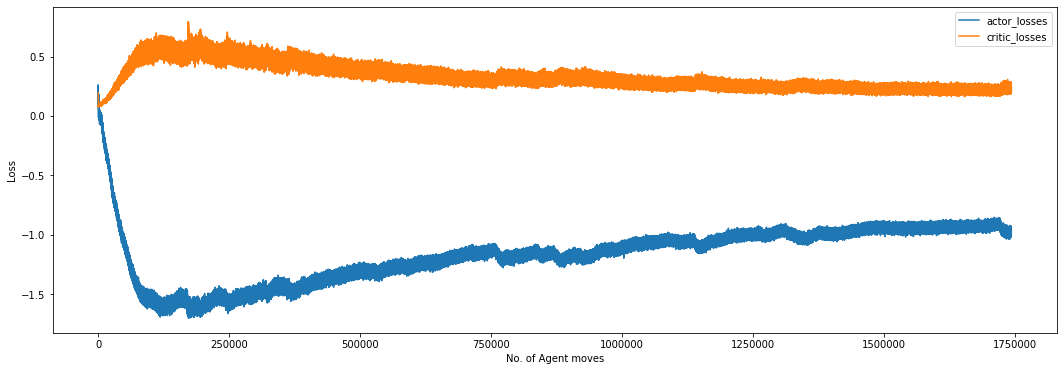

In [30]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [35]:
controller.reset_game(drl_checkpoint_path=f'../checkpoints/{MODEL_VERSION}_model.pt')

Select one of the following players to be player 1
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
3 - ./models/players\semi_random_player.py
Input desired player number: 1
player_class.__name__ = HumanPlayer
Select one of the following players to be player 2
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
3 - ./models/players\semi_random_player.py
Input desired player number: 0
player_class.__name__ = DRLPlayer
player_kwargs['initial_checkpoint_path'] = drl_checkpoint_path = ../checkpoints/v8_model.pt
initial_checkpoint_path: ../checkpoints/v8_model.pt
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X): 100           Player 2 (O): 100

Player 1 HumanPlayer(X) bidding...
15
Player 2 DRLPlayer(O) bidding...
Player 1 HumanPlayer(X) bid: 15  |  Player 2 DRLPlaye

In [20]:
run_validation(players, 1000)

0.795